In [1]:
import sys, os
sys.path.append(os.path.realpath("../../../"))

In [1]:
%pip install treasury-ml-utils --extra-index-url https://arti.tw.ee/artifactory/api/pypi/pypi-internal/simple

Looking in indexes: https://pypi.org/simple, https://arti.tw.ee/artifactory/api/pypi/pypi-internal/simple
  Using cached numpy-1.26.4-cp311-cp311-macosx_11_0_arm64.whl.metadata (114 kB)
  Using cached pandas-1.5.3-cp311-cp311-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached slack_sdk-3.37.0-py2.py3-none-any.whl.metadata (15 kB)
  Using cached jmespath-1.0.1-py3-none-any.whl.metadata (7.6 kB)
  Using cached urllib3-2.5.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached charset_normalizer-3.4.4-cp311-cp311-macosx_10_9_universal2.whl.metadata (37 kB)
  Using cached idna-3.11-py3-none-any.whl.metadata (8.4 kB)
  Using cached certifi-2025.10.5-py3-none-any.whl.metadata (2.5 kB)
INFO: pip is looking at multiple versions of s3transfer to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 13.4 MB/s  0:00:01 eta 0:00:01
Using cached

In [2]:
from treasury_ml_utils.snowflake_utils import SnowflakeConnector

snowflake_client = SnowflakeConnector("joshua.choy@transferwise.com")

10.1.1


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

#hourly_data = pd.ExcelFile('data_hourly.xlsx')
#sheet_names =hourly_data.sheet_names

In [4]:
df = snowflake_client.fetch(f"""
SELECT *, 
       CONVERT_TIMEZONE('UTC', 'America/New_York', TIMESTAMP) as NY_TIME,
       ((BID_OUTRIGHT+OFFER_OUTRIGHT)/2) as mid
FROM RPT_TREASURY.INT_ASSET_PRICING__FX_QUOTE_SNAPSHOT_HOURLY
WHERE CCY_PAIR IN ('EURUSD', 'GBPUSD', 'EURGBP', 'USDJPY', 'USDMXN','USDBRL', 'USDCOP', 'USDCNY', 'USDIDR', 'USDINR','USDMYR', 'USDPHP', 'USDKRW', 'USDTWD', 'USDTHB', 'USDVND')
  AND TENOR_CODE = 'SP'
  AND INSTRUMENT_TYPE = 'FXSpot'
  AND PROVIDER = 'BLOOMBERG'
  AND TIMESTAMP BETWEEN '2025-01-01 00:00:00' AND '2026-01-26 00:00:00'  
  

  AND DAYOFWEEKISO(CONVERT_TIMEZONE('UTC', 'America/New_York', TIMESTAMP)) <> 6
  AND NOT (DAYOFWEEKISO(CONVERT_TIMEZONE('UTC', 'America/New_York', TIMESTAMP)) = 5 AND HOUR(CONVERT_TIMEZONE('UTC', 'America/New_York', TIMESTAMP)) >= 17)
  AND NOT (DAYOFWEEKISO(CONVERT_TIMEZONE('UTC', 'America/New_York', TIMESTAMP)) = 7 AND HOUR(CONVERT_TIMEZONE('UTC', 'America/New_York', TIMESTAMP)) < 17);
""")

ccy_df = df.pivot(index='timestamp', columns='ccy_pair', values='mid')
ccy_df.head()

ccy_pair,EURUSD,GBPUSD,USDBRL,USDCNY,USDCOP,USDIDR,USDINR,USDJPY,USDKRW,USDMXN,USDMYR,USDPHP,USDTHB,USDTWD,USDVND
timestamp,,,,,,,,,,,,,,,
2025-01-01 00:00:00,1.0359,1.2508,6.17725,7.29935,4405.775,16101.5,85.60875,157.2,1471.95,20.8205,4.47225,57.8435,34.095,32.79,25486.75
2025-01-01 01:00:00,1.0359,1.2508,6.17725,7.29935,4405.775,16101.5,85.60875,157.2,1471.95,20.8205,4.47225,57.8435,34.095,32.79,25486.75
2025-01-01 02:00:00,1.0359,1.2508,6.17725,7.29935,4405.775,16101.5,85.60875,157.2,1471.95,20.8205,4.47225,57.8435,34.095,32.79,25486.75
2025-01-01 03:00:00,1.0359,1.2508,6.17725,7.29935,4405.775,16101.5,85.60875,157.2,1471.95,20.8205,4.47225,57.8435,34.095,32.79,25488.05
2025-01-01 04:00:00,1.0359,1.2508,6.17725,7.29935,4405.775,16101.5,85.67000,157.2,1471.95,20.8205,4.47225,57.8435,34.095,32.79,25488.05


In [5]:
ccy_df['EURGBP'] = ccy_df['EURUSD']/ccy_df['GBPUSD']
ccy_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6602 entries, 2025-01-01 00:00:00 to 2026-01-26 00:00:00
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EURUSD  6602 non-null   float64
 1   GBPUSD  6602 non-null   float64
 2   USDBRL  6602 non-null   float64
 3   USDCNY  6602 non-null   float64
 4   USDCOP  6602 non-null   float64
 5   USDIDR  6602 non-null   float64
 6   USDINR  6602 non-null   float64
 7   USDJPY  6602 non-null   float64
 8   USDKRW  6602 non-null   float64
 9   USDMXN  6602 non-null   float64
 10  USDMYR  6602 non-null   float64
 11  USDPHP  6602 non-null   float64
 12  USDTHB  6602 non-null   float64
 13  USDTWD  6602 non-null   float64
 14  USDVND  6602 non-null   float64
 15  EURGBP  6602 non-null   float64
dtypes: float64(16)
memory usage: 876.8 KB


In [6]:
# rebasing all CCYs to USD

rebased_ccy_df = ccy_df.copy()
rebased_ccy_df['GBPUSD'] = 1 / rebased_ccy_df['GBPUSD']
rebased_ccy_df['EURUSD'] = 1 / rebased_ccy_df['EURUSD']


rebased_ccy_df.rename(columns={
                  'GBPUSD': 'USDGBP',
                  'EURUSD': 'USDEUR',
                  }, inplace=True
                  )

rebased_ccy_df.head()

ccy_pair,USDEUR,USDGBP,USDBRL,USDCNY,USDCOP,USDIDR,USDINR,USDJPY,USDKRW,USDMXN,USDMYR,USDPHP,USDTHB,USDTWD,USDVND,EURGBP
timestamp,,,,,,,,,,,,,,,,
2025-01-01 00:00:00,0.965344,0.799488,6.17725,7.29935,4405.775,16101.5,85.60875,157.2,1471.95,20.8205,4.47225,57.8435,34.095,32.79,25486.75,0.82819
2025-01-01 01:00:00,0.965344,0.799488,6.17725,7.29935,4405.775,16101.5,85.60875,157.2,1471.95,20.8205,4.47225,57.8435,34.095,32.79,25486.75,0.82819
2025-01-01 02:00:00,0.965344,0.799488,6.17725,7.29935,4405.775,16101.5,85.60875,157.2,1471.95,20.8205,4.47225,57.8435,34.095,32.79,25486.75,0.82819
2025-01-01 03:00:00,0.965344,0.799488,6.17725,7.29935,4405.775,16101.5,85.60875,157.2,1471.95,20.8205,4.47225,57.8435,34.095,32.79,25488.05,0.82819
2025-01-01 04:00:00,0.965344,0.799488,6.17725,7.29935,4405.775,16101.5,85.67000,157.2,1471.95,20.8205,4.47225,57.8435,34.095,32.79,25488.05,0.82819


In [7]:
# removing weekends

rebased_ccy_df.columns

Index(['USDEUR', 'USDGBP', 'USDBRL', 'USDCNY', 'USDCOP', 'USDIDR', 'USDINR',
       'USDJPY', 'USDKRW', 'USDMXN', 'USDMYR', 'USDPHP', 'USDTHB', 'USDTWD',
       'USDVND', 'EURGBP'],
      dtype='object', name='ccy_pair')

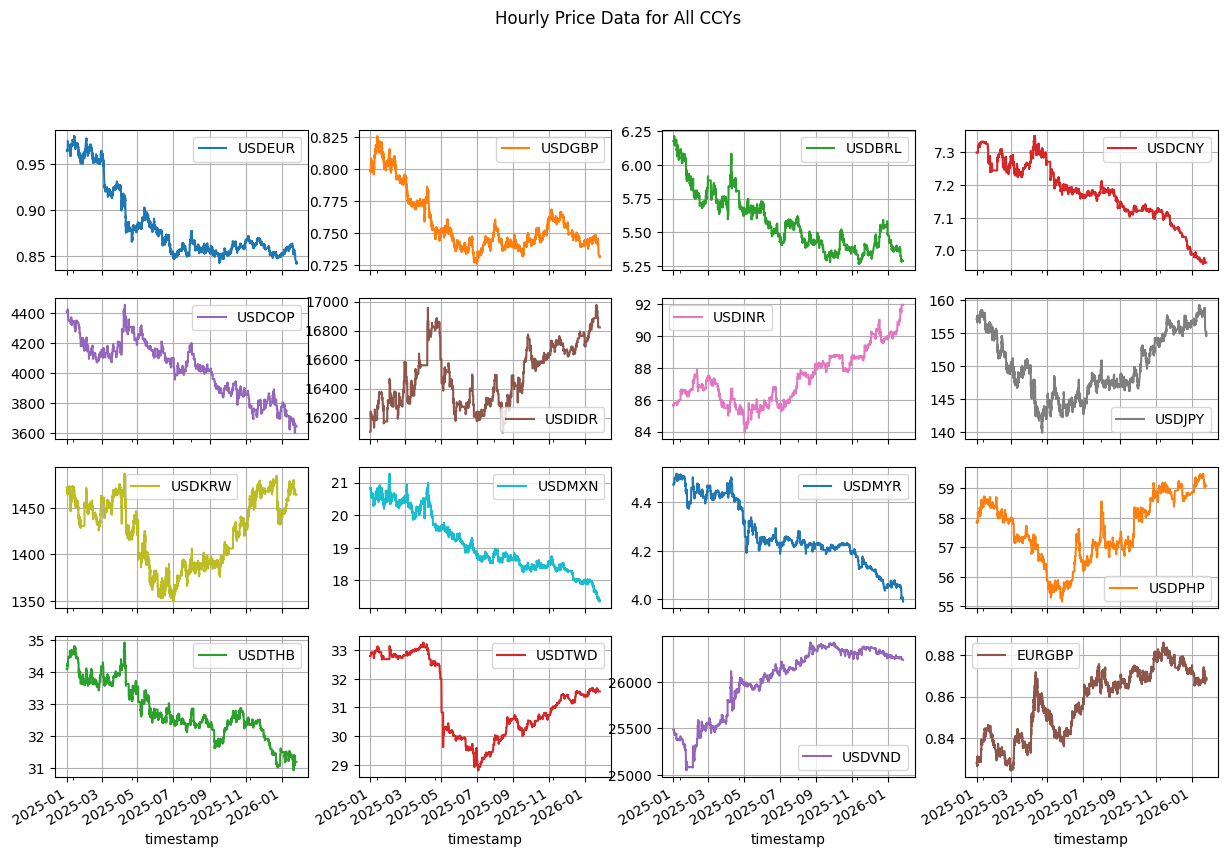

In [8]:
# plotting all ccys graphically

rebased_ccy_df.plot(
    subplots=True,
    layout=(5,4),
    figsize=(15,12),
    title='Hourly Price Data for All CCYs',
    grid=True,
    sharex=True
)
plt.show()

In [20]:
# calculating log hourly returns

log_returns = np.log(rebased_ccy_df/rebased_ccy_df.shift(1))
log_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6602 entries, 2025-01-01 00:00:00 to 2026-01-26 00:00:00
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   USDEUR  6601 non-null   float64
 1   USDGBP  6601 non-null   float64
 2   USDBRL  6601 non-null   float64
 3   USDCNY  6601 non-null   float64
 4   USDCOP  6601 non-null   float64
 5   USDIDR  6601 non-null   float64
 6   USDINR  6601 non-null   float64
 7   USDJPY  6601 non-null   float64
 8   USDKRW  6601 non-null   float64
 9   USDMXN  6601 non-null   float64
 10  USDMYR  6601 non-null   float64
 11  USDPHP  6601 non-null   float64
 12  USDTHB  6601 non-null   float64
 13  USDTWD  6601 non-null   float64
 14  USDVND  6601 non-null   float64
 15  EURGBP  6601 non-null   float64
dtypes: float64(16)
memory usage: 876.8 KB


In [101]:
# mostly em pairs with many zeroes on log returns?

log_returns.describe()

ccy_pair,USDEUR,USDGBP,USDBRL,USDCNY,USDCOP,USDIDR,USDINR,USDJPY,USDKRW,USDMXN,USDMYR,USDPHP,USDTHB,USDTWD,USDVND,EURGBP
count,6601.000000,6601.000000,6601.000000,6601.000000,6601.000000,6601.000000,6601.000000,6601.000000,6.601000e+03,6601.000000,6601.000000,6601.000000,6601.000000,6601.000000,6601.000000,6601.000000
mean,-0.000021,-0.000013,-0.000024,-0.000007,-0.000029,0.000007,0.000011,-0.000002,-8.204267e-07,-0.000027,-0.000017,0.000003,-0.000013,-0.000006,0.000004,0.000007
std,0.001003,0.000934,0.001403,0.000303,0.001569,0.000630,0.000547,0.001199,1.169851e-03,0.001295,0.000662,0.000630,0.000924,0.000802,0.000296,0.000656
min,-0.012288,-0.009605,-0.021679,-0.004666,-0.021722,-0.007888,-0.010130,-0.012569,-1.386881e-02,-0.025468,-0.008194,-0.010995,-0.012170,-0.039961,-0.004435,-0.005730
25%,-0.000427,-0.000443,0.000000,-0.000036,0.000000,0.000000,0.000000,-0.000541,-2.167943e-04,-0.000509,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000286
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,-0.000020,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000425,0.000409,0.000000,0.000034,0.000000,0.000000,0.000000,0.000577,3.068897e-04,0.000438,0.000000,0.000000,0.000000,0.000000,0.000004,0.000287
max,0.013295,0.009467,0.022592,0.005520,0.025543,0.016262,0.007451,0.014794,1.636312e-02,0.022321,0.008509,0.007983,0.014586,0.012071,0.006227,0.004629


## generic pearson correlation

In [104]:
def correlations(df, target: list, feature_cols: list, method: str, window :int, min_frac: float):
    '''
    :param dataframe: dataframe of log returns
    :param target: list of target variables
    :param feature_cols: list of feature ccys that we want to run correlations for
    :param method: string of type of correlation method
    :param window: int of window size
    '''
    min_per = int(window*min_frac)
    correlations = {}


    for t in target:
        for f in feature_cols:
            key = f"{f} vs {t}"
            x = df[f].to_numpy()
            y = df[t].to_numpy()

            # creating the resulting array first
            res = np.full(len(df), np.nan, dtype=float)

            for i in range(window-1, len(df)):
                xs = x[i-window+1: i+1]
                ys = y[i-window+1: i+1] # 2 vectors to calculate correlation 
                ok = np.isfinite(xs) & np.isfinite(ys)
                xs, ys = xs[ok], ys[ok] # keep only valid observations

                if len(xs) < min_per:
                    continue

                if method == 'pearson':
                    r = scipy.stats.pearsonr(xs, ys)[0]
                elif method == 'spearman':
                    r = scipy.stats.spearmanr(xs, ys)[0]
                elif method == 'kendall':
                    r = scipy.stats.kendalltau(xs, ys)[0]
                else:
                    raise ValueError("method must be pearson, spearman or kendall")
                
                res[i] = r
        
            correlations[key] = pd.Series(res, index=df.index)
                    
    
    return pd.DataFrame(correlations)

In [97]:
def correlations(dataframe, target: list, feature_cols: list, method: str, window :int):
    '''
    :param dataframe: dataframe of log returns
    :param target: list of target variables
    :param feature_cols: list of feature ccys that we want to run correlations for
    :param method: string of type of correlation method
    :param window: int of window size
    '''
    correlations = {}

    for target_ccy in target:
        for feature_ccy in feature_cols:
            # calculating rolling correlation
            pair = f"{feature_ccy} VS {target_ccy}"
            if method == 'pearson':
                correlations[pair] = dataframe[feature_ccy].rolling(window).corr(dataframe[target_ccy], method = 'pearson')
            elif method == 'spearman':
                correlations[pair] = dataframe[feature_ccy].rolling(window).corr(dataframe[target_ccy], method = 'spearman')
            elif method == 'kendall':
                correlations[pair] = dataframe[feature_ccy].rolling(window).corr(dataframe[target_ccy], method = 'kendall')
                

    return pd.DataFrame(correlations)

In [105]:
em_pairs = ['USDCNY', 'USDKRW', 'USDMYR', 'USDINR', 'USDIDR', 'USDPHP', 'USDTWD','USDTHB', 'USDMXN', 'USDBRL', 'USDCOP']
majors = ['USDEUR', 'USDGBP', 'EURGBP']

pearson_df  = correlations(log_returns, majors, em_pairs, window=24*5, method="pearson", min_frac = 0.8)
spearman_df = correlations(log_returns, majors, em_pairs, window=24*5, method="spearman", min_frac = 0.8)
kendall_df  = correlations(log_returns, majors, em_pairs, window=24*5, method="kendall", min_frac = 0.8)

/var/folders/r6/lyd4620542j8pdy7dl_ccjtw0000gp/T/ipykernel_97166/3567466845.py:32: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.pearsonr(xs, ys)[0]
/var/folders/r6/lyd4620542j8pdy7dl_ccjtw0000gp/T/ipykernel_97166/3567466845.py:34: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = scipy.stats.spearmanr(xs, ys)[0]


In [109]:
pearson_df

,USDCNY vs USDEUR,USDKRW vs USDEUR,USDMYR vs USDEUR,USDINR vs USDEUR,USDIDR vs USDEUR,USDPHP vs USDEUR,USDTWD vs USDEUR,USDTHB vs USDEUR,USDMXN vs USDEUR,USDBRL vs USDEUR,...,USDKRW vs EURGBP,USDMYR vs EURGBP,USDINR vs EURGBP,USDIDR vs EURGBP,USDPHP vs EURGBP,USDTWD vs EURGBP,USDTHB vs EURGBP,USDMXN vs EURGBP,USDBRL vs EURGBP,USDCOP vs EURGBP
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-01-23 20:00:00,0.060601,0.243861,-0.047057,0.066115,0.003397,0.077223,-0.088521,0.131574,0.212395,0.078885,...,-0.056707,-0.107400,-0.063232,0.108462,0.031660,-0.038514,-0.046983,0.209507,0.266265,-0.013893
2026-01-23 21:00:00,0.060101,0.242544,-0.048432,0.067035,0.002980,0.076251,-0.088217,0.130849,0.209766,0.079312,...,-0.057198,-0.108991,-0.062233,0.108228,0.031051,-0.038578,-0.047284,0.216063,0.267434,-0.014242
2026-01-25 22:00:00,0.053529,0.221689,-0.057526,0.072543,-0.000515,0.065183,-0.082048,0.119474,0.225767,0.066523,...,-0.055687,-0.104998,-0.063577,0.107341,0.031716,-0.038011,-0.046212,0.165278,0.265054,-0.013421


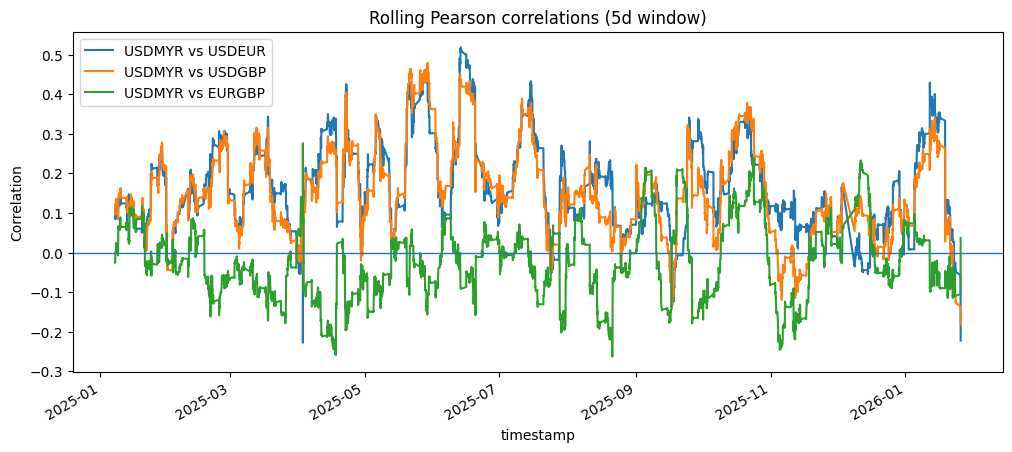

In [110]:
cols = ['USDMYR vs USDEUR', 'USDMYR vs USDGBP', 'USDMYR vs EURGBP']

ax = pearson_df[cols].dropna().plot(figsize=(12,5))
ax.axhline(0, linewidth=1)
ax.set_title("Rolling Pearson correlations (5d window)")
ax.set_ylabel("Correlation")
plt.show()

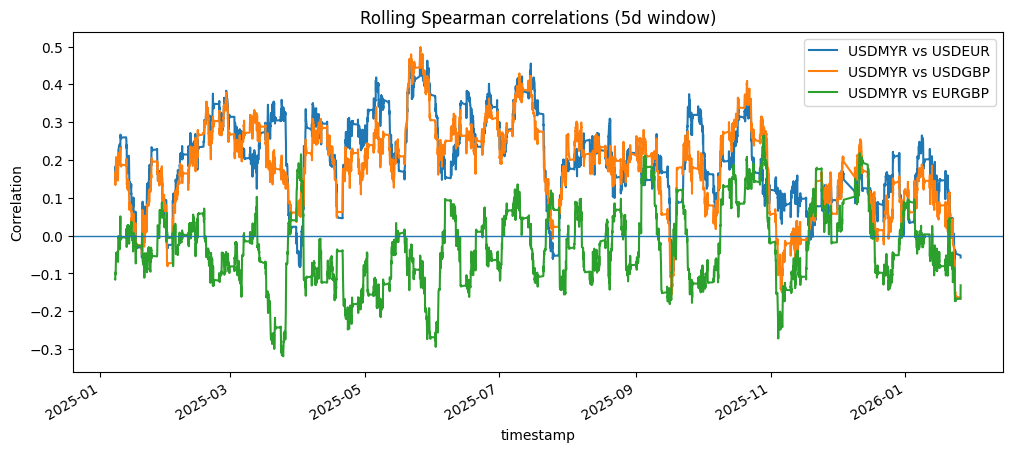

In [112]:
cols = ['USDMYR vs USDEUR', 'USDMYR vs USDGBP', 'USDMYR vs EURGBP']

ax = spearman_df[cols].dropna().plot(figsize=(12,5))
ax.axhline(0, linewidth=1)
ax.set_title("Rolling Spearman correlations (5d window)")
ax.set_ylabel("Correlation")
plt.show()

In [21]:
# for usdgbp

import plotly.express as px

# Filter just the data we want to plot
plot_data = daily_corr[usdgbp_cols].reset_index()

# Create interactive line chart
fig = px.line(plot_data, x='timestamp', y=usdgbp_cols,
              title='Daily Rolling Correlations vs USDGBP (Interactive - Zoom in!)',
              labels={'value': 'Correlation', 'variable': 'Currency Pair'})

# Customize: Add a range slider and highlight the 0 line
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True), # Adds a slider at the bottom
        type="date"
    ),
    yaxis=dict(range=[-1, 1]) # Fix y-axis to standard correlation limits
)

# Add a zero line to easily see when correlations flip negative
fig.add_hline(y=0, line_dash="dash", line_color="black")

fig.show()

In [22]:
# correlation ag gbp

# 1. Create a Month column
daily_corr['Month'] = daily_corr.index.month

# 2. Group by Month and take the average (Aggregating all years together)
# This creates a "Typical Year" profile for each currency
seasonality_matrix = daily_corr.groupby('Month')[usdgbp_cols].mean().T

# 3. Plot Heatmap
fig = px.imshow(seasonality_matrix,
                labels=dict(x="Month of Year", y="Currency Pair", color="Avg Correlation"),
                x=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                color_continuous_scale='RdBu', # Red=High Corr, Blue=Inverse/Low
                zmin=-0.5, zmax=0.8, # Lock scale to see contrast
                title="Seasonality Heatmap: Do correlations cool off in Nov/Dec?")

fig.show()

In [23]:
# correlation ag eur

# 1. Create a Month column
daily_corr['Month'] = daily_corr.index.month

# 2. Group by Month and take the average (Aggregating all years together)
# This creates a "Typical Year" profile for each currency
seasonality_matrix = daily_corr.groupby('Month')[usdeur_cols].mean().T

# 3. Plot Heatmap
fig = px.imshow(seasonality_matrix,
                labels=dict(x="Month of Year", y="Currency Pair", color="Avg Correlation"),
                x=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                color_continuous_scale='RdBu', # Red=High Corr, Blue=Inverse/Low
                zmin=-0.5, zmax=0.8, # Lock scale to see contrast
                title="Seasonality Heatmap: Do correlations cool off in Nov/Dec?")

fig.show()

<Figure size 1000x800 with 0 Axes>

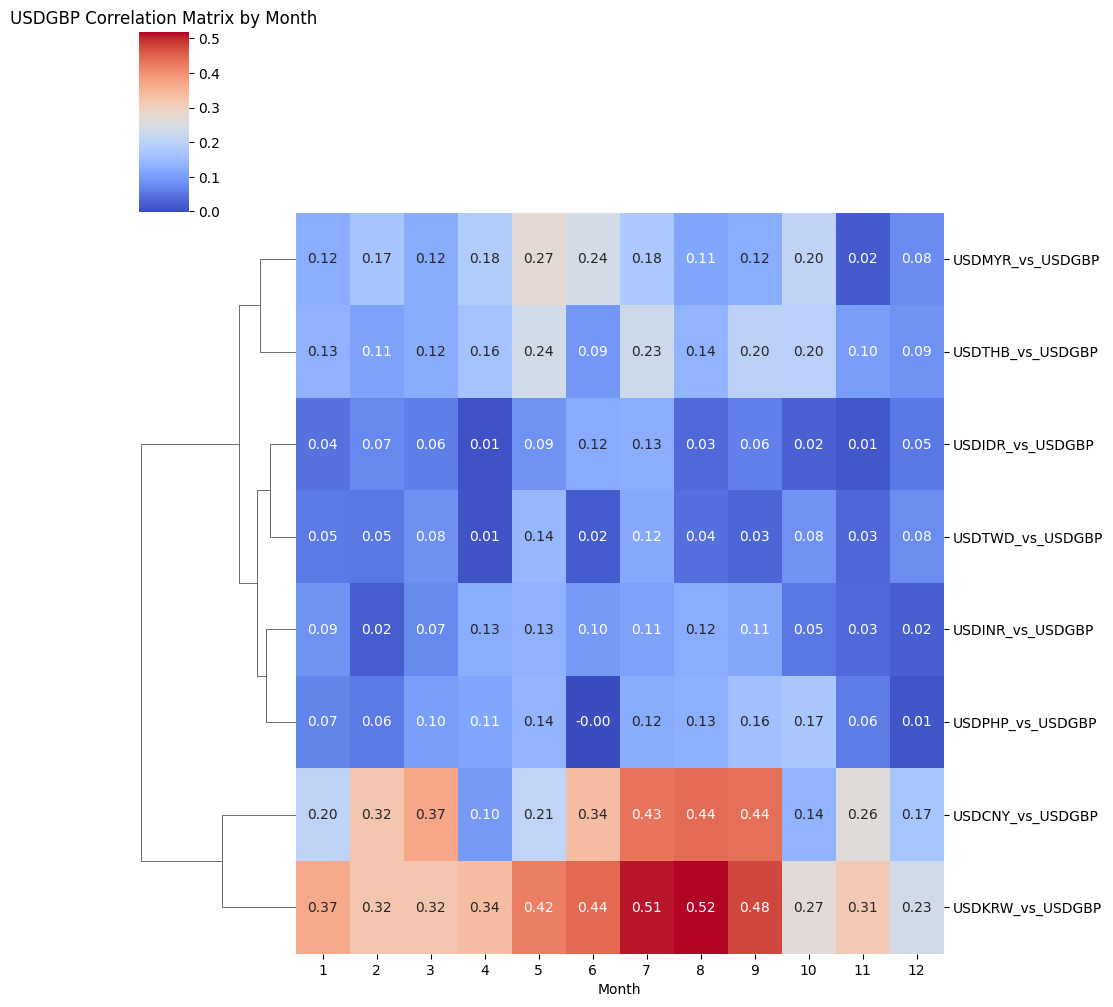

In [24]:
# plotting out correlation matrix

matrix = daily_corr.groupby('Month')[usdgbp_cols].mean().T

plt.figure(figsize=(10,8))
sns.clustermap(
    matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    col_cluster=False
)
plt.title('USDGBP Correlation Matrix by Month')
plt.show()

<Figure size 1000x800 with 0 Axes>

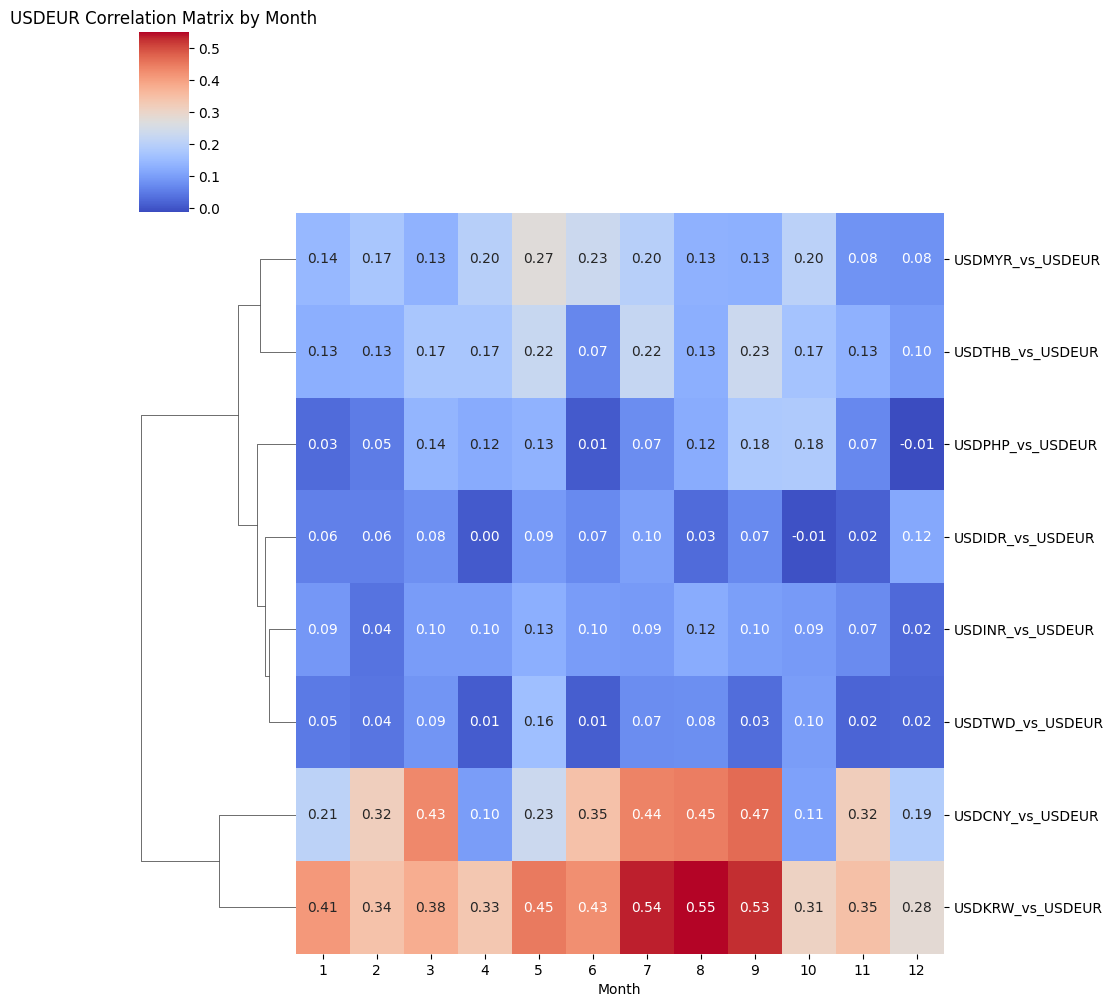

In [25]:
# plotting out correlation matrix

matrix = daily_corr.groupby('Month')[usdeur_cols].mean().T

plt.figure(figsize=(10,8))
sns.clustermap(
    matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    col_cluster=False
)
plt.title('USDEUR Correlation Matrix by Month')
plt.show()
